# Clustering Crypto

In [33]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path

### Fetching Cryptocurrency Data

In [34]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [35]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [36]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
crypto_df = pd.read_csv(file_path, index_col = 0)
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [37]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply\

In [38]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df.loc[crypto_df["IsTrading"] == True]

In [39]:
# Keep only cryptocurrencies with a working algorithm

In [40]:
# Remove the "IsTrading" column
crypto_df.drop("IsTrading", axis=1, inplace=True)

In [41]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace=True)


In [42]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df.loc[crypto_df["TotalCoinsMined"] > 0]

In [43]:
# Drop rows where there are 'N/A' text values
crypto_df.isnull().sum()

CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

In [44]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_df = pd.DataFrame(data=crypto_df, columns=["CoinName"])

In [45]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop("CoinName", axis=1, inplace=True)

In [46]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df, columns=["Algorithm", "ProofType"])
X.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# Standardize data
crypto_scaled = StandardScaler().fit_transform(X)

### Reducing Dimensions Using PCA

In [48]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)

crypto_pca = pca.fit_transform(crypto_scaled)

In [49]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(data=crypto_pca, columns=["PC 1", "PC 2", "PC 3"], index=crypto_df.index)
pcs_df.head(10)

,PC 1,PC 2,PC 3
42,-0.335426,1.088878,-0.519583
404,-0.318779,1.088816,-0.520010
1337,2.290693,1.561966,-0.591831
BTC,-0.150023,-1.356125,0.128056
ETH,-0.153715,-2.084078,0.329279
LTC,-0.161045,-1.058812,-0.015469
DASH,-0.398862,1.200159,-0.464632
XMR,-0.144953,-2.208675,0.333662
ETC,-0.152159,-2.084203,0.329259
ZEC,-0.142119,-1.987224,0.388839


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [50]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")


:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [51]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(pcs_df)
# Predict clusters
predictions = model.predict(pcs_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
pcs_df["class"] = model.labels_
clustered_df = pd.concat([coin_df, crypto_df, pcs_df], axis=1)
clustered_df.head(10)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,class
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42,-0.335426,1.088878,-0.519583,0
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.318779,1.088816,-0.520010,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359,2.290693,1.561966,-0.591831,0
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000,-0.150023,-1.356125,0.128056,2
ETH,Ethereum,Ethash,PoW,1.076842e+08,0,-0.153715,-2.084078,0.329279,2
LTC,Litecoin,Scrypt,PoW,6.303924e+07,84000000,-0.161045,-1.058812,-0.015469,2
DASH,Dash,X11,PoW/PoS,9.031294e+06,22000000,-0.398862,1.200159,-0.464632,0
XMR,Monero,CryptoNight-V7,PoW,1.720114e+07,0,-0.144953,-2.208675,0.333662,2
ETC,Ethereum Classic,Ethash,PoW,1.133597e+08,210000000,-0.152159,-2.084203,0.329259,2
ZEC,ZCash,Equihash,PoW,7.383056e+06,21000000,-0.142119,-1.987224,0.388839,2


### Visualizing Results

#### 3D-Scatter with Clusters

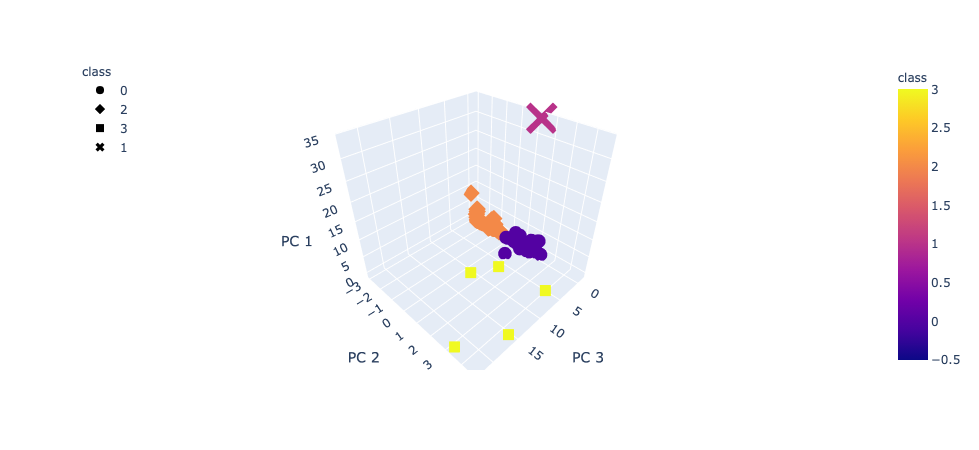

In [52]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 3",
    y="PC 2",
    z="PC 1",
    hover_name='CoinName',
    hover_data= ['Algorithm'],
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()


#### Table of Tradable Cryptocurrencies

In [53]:
# Table with tradable cryptos
columns = ['CoinName', 'Algorithm', 'ProofType', 'TotalCoinSupply', 'TotalCoinsMined', 'class']
clustered_df.hvplot.table(columns, width=800)


:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,class]

In [54]:
# Print the total number of tradable cryptocurrencies
count = clustered_df['CoinName'].count()
print(f"There are {count} tradable cryptocurrencies")


There are 532 tradable cryptocurrencies


#### Scatter Plot with Tradable Cryptocurrencies

In [65]:
# Scale data to create the scatter plot
clustered_df['TotalCoinsMined'] = clustered_df['TotalCoinsMined'].astype(float) / 1000000
clustered_df['TotalCoinSupply'] = clustered_df['TotalCoinSupply'].astype(float) / 1000000



In [66]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot.scatter(
    x="TotalCoinsMined", 
    y="TotalCoinSupply",
    hover_cols=["CoinName"]
)

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)